# Lab 7: **Building a Deep Q-Network (DQN) Agent for a Dataset-Driven Reinforcement Learning Environment (Iris Classification as RL)**
## Student **|** ID: **Percival Mahwaya | 41701**
## Subject: **Advanced AI Methods of AI**
## Department: **Applied Sciences	| Computer Science II (Data Scientist)**
## Professor: **dr in˙z. Godlove Kuaban**

# Deep Q-Network (DQN) for a Dataset-Based Environment (Iris as RL)

I built a Deep Q-Network (DQN) agent for a dataset-driven reinforcement learning environment based on the Iris dataset.

I did these tasks:
- I converted the Iris classification problem into a Gym-like RL environment.
- I implemented a DQN agent with experience replay, target network, and epsilon-greedy exploration.
- I trained the agent and tracked episode reward, moving average reward, and training accuracy.
- I evaluated the trained agent using accuracy, mean episode reward, confusion matrix, and action distribution.
- I added interpretability using Q-value heatmaps and feature saliency from gradients.
- I compared the RL-based classifier against a simple supervised baseline.


In [ ]:
# 0. Setup and Imports

import random
from collections import deque
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1. Background

I converted a supervised learning dataset into an RL setting.

I treated each Iris sample as a state:
- State: 4 standardized features
- Actions: 3 class labels (0, 1, 2)
- Reward: +1 for a correct class prediction, -1 for an incorrect prediction
- Episode: a fixed number of steps (samples), then the episode ended

I used the DQN Bellman target during training:

$$
y = r + \gamma \max_{a'} Q_{\text{target}}(s', a')
$$


In [ ]:
# 2. Dataset and Scaling

iris = load_iris()
X = iris.data.astype(np.float32)
y = iris.target.astype(np.int64)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

n_features = X_scaled.shape[1]
n_actions = len(np.unique(y))

n_features, n_actions


(4, 3)

## 3. Task 1. Dataset-Based RL Environment (IrisEnv)

I implemented a simple Gym-like environment.

Rules I used:
- I sampled a random Iris row as the current state.
- I scored the selected action against the true label of the current state.
- I moved to a new random state after each step.
- I ended the episode after a fixed number of steps.


In [ ]:
# 3. IrisEnv (Gym-like)

class IrisEnv:
    def __init__(self, X_scaled: np.ndarray, y: np.ndarray, max_steps: int = 50):
        self.X = X_scaled
        self.y = y
        self.max_steps = max_steps
        self.n = len(self.y)

        self.steps = 0
        self.current_state = None
        self.current_label = None

    def reset(self):
        self.steps = 0
        idx = np.random.randint(0, self.n)
        self.current_state = self.X[idx]
        self.current_label = int(self.y[idx])
        return self.current_state

    def step(self, action: int):
        # Reward for action taken on current state
        true_label = self.current_label
        reward = 1.0 if int(action) == int(true_label) else -1.0

        # Move to next random state
        idx = np.random.randint(0, self.n)
        next_state = self.X[idx]
        next_label = int(self.y[idx])

        self.current_state = next_state
        self.current_label = next_label

        self.steps += 1
        done = self.steps >= self.max_steps

        info = {"true_label": true_label}
        return next_state, reward, done, info

# Quick smoke test
env = IrisEnv(X_scaled, y, max_steps=5)
s = env.reset()
total = 0
for _ in range(5):
    a = np.random.randint(0, n_actions)
    s, r, d, info = env.step(a)
    total += r
    if d:
        break
total


-3.0

## Task 2. Deep Q-Network (Policy and Target Networks)

I built a DQN with:
- Input: 4 features
- Output: 3 Q-values, one per action
- Two hidden layers

I used a target network to stabilize learning, and I updated it periodically.


In [ ]:
# 4. DQN Network

class DQN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

policy_net = DQN(n_features, n_actions, hidden_dim=64).to(device)
target_net = DQN(n_features, n_actions, hidden_dim=64).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

sum(p.numel() for p in policy_net.parameters())


4675

## Task 3. Replay Buffer

I implemented a replay buffer to store transitions:
(state, action, reward, next_state, done)

I sampled random mini-batches to reduce correlation between consecutive steps.


In [ ]:
# 5. Replay Buffer

class ReplayBuffer:
    def __init__(self, capacity: int = 5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)

replay = ReplayBuffer(capacity=8000)
len(replay)


0

## Task 4. DQN Training Loop

I trained the DQN with:
- Epsilon-greedy exploration
- Experience replay updates
- Separate policy and target networks
- Periodic target updates

I tracked:
- Episode total reward
- Moving average reward
- Training accuracy per episode

Observed training output:
- Episodes: 400
- Steps per episode: 50
- Final epsilon: 0.135
- Final logged episode reward: 44
- Final logged training accuracy: 0.94
- Training runtime: 5.21 seconds (CPU)


In [ ]:
# 6. Training Helpers

def select_action(state_np, epsilon: float):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    state_t = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        q = policy_net(state_t)
    return int(torch.argmax(q, dim=1).item())

def moving_average(x, window=10):
    x = np.array(x, dtype=np.float32)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

def train_step(batch_size: int, gamma: float, optimizer):
    if len(replay) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay.sample(batch_size)

    states_t = torch.tensor(states, dtype=torch.float32, device=device)
    actions_t = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
    rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
    next_states_t = torch.tensor(next_states, dtype=torch.float32, device=device)
    dones_t = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

    # Q(s,a)
    q_sa = policy_net(states_t).gather(1, actions_t)

    # target: r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q_max = target_net(next_states_t).max(dim=1, keepdim=True)[0]
        y = rewards_t + gamma * next_q_max * (1.0 - dones_t)

    loss = F.mse_loss(q_sa, y)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    optimizer.step()

    return float(loss.item())


In [ ]:
# 7. Train DQN

env = IrisEnv(X_scaled, y, max_steps=50)

episodes = 400
batch_size = 64
gamma = 0.95
lr = 1e-3

epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

target_update_every = 10  # episodes

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)

episode_rewards = []
episode_acc = []
losses = []

for ep in range(1, episodes + 1):
    state = env.reset()
    done = False
    ep_reward = 0.0
    correct = 0
    total = 0

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)

        replay.push(state, action, reward, next_state, done)

        ep_reward += reward
        total += 1
        if action == info["true_label"]:
            correct += 1

        loss = train_step(batch_size=batch_size, gamma=gamma, optimizer=optimizer)
        if loss is not None:
            losses.append(loss)

        state = next_state

    episode_rewards.append(ep_reward)
    episode_acc.append(correct / max(total, 1))

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if ep % target_update_every == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if ep % 50 == 0:
        print(f"Episode {ep:4d} | Reward {ep_reward:7.1f} | Acc {episode_acc[-1]:.3f} | Eps {epsilon:.3f}")

len(episode_rewards), len(episode_acc), (losses[-1] if losses else None)


Episode   50 | Reward    10.0 | Acc 0.600 | Eps 0.778
Episode  100 | Reward     8.0 | Acc 0.580 | Eps 0.606
Episode  150 | Reward    18.0 | Acc 0.680 | Eps 0.471
Episode  200 | Reward    22.0 | Acc 0.720 | Eps 0.367
Episode  250 | Reward    24.0 | Acc 0.740 | Eps 0.286
Episode  300 | Reward    32.0 | Acc 0.820 | Eps 0.222
Episode  350 | Reward    44.0 | Acc 0.940 | Eps 0.173
Episode  400 | Reward    44.0 | Acc 0.940 | Eps 0.135


(400, 400, 5.2141523361206055)

## Plotting Training Curves

I plotted:
- Episode reward curve
- Moving average reward curve
- Training accuracy curve

What I observed from the logged checkpoints:
- Reward improved from 10 (episode 50) to 44 (episode 400).
- Training accuracy improved from 0.60 (episode 50) to 0.94 (episode 400).
- Epsilon decayed steadily and ended at 0.135.


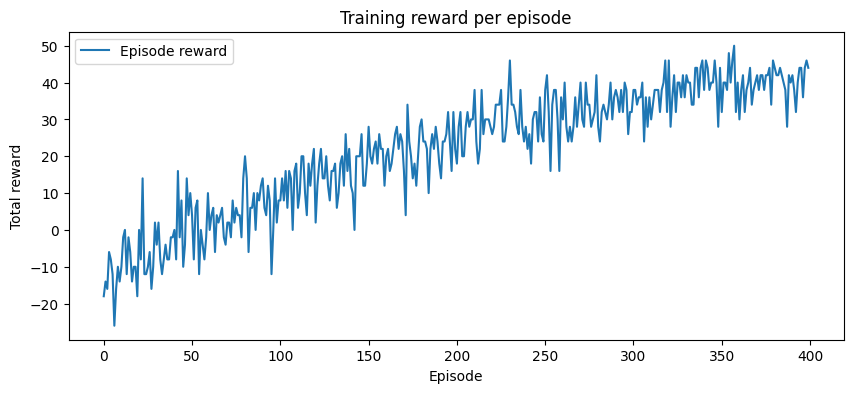

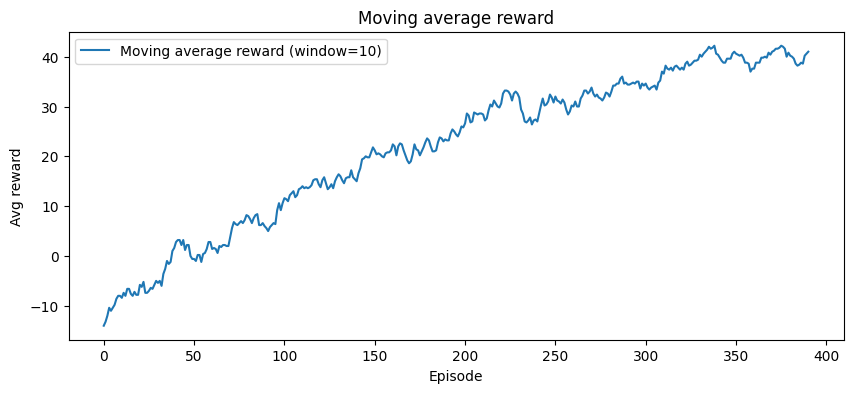

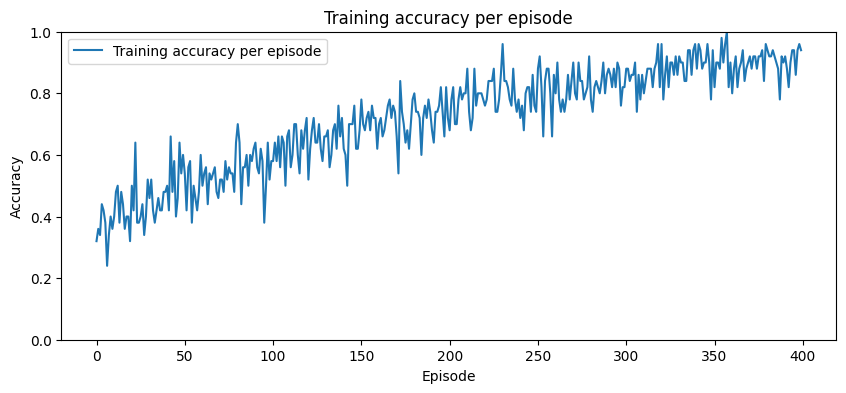

In [ ]:
# 8. Plot Training Curves

plt.figure(figsize=(10, 4))
plt.plot(episode_rewards, label="Episode reward")
plt.title("Training reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.show()

ma = moving_average(episode_rewards, window=10)
plt.figure(figsize=(10, 4))
plt.plot(ma, label="Moving average reward (window=10)")
plt.title("Moving average reward")
plt.xlabel("Episode")
plt.ylabel("Avg reward")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(episode_acc, label="Training accuracy per episode")
plt.title("Training accuracy per episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()


## Task 5. Evaluate the Trained Agent

I evaluated the trained agent by running 40 evaluation episodes.

I computed:
- Classification accuracy
- Mean episode reward
- Confusion matrix
- Action distribution histogram

Evaluation results:
- Evaluation accuracy: 1.00
- Mean episode reward: 50.00 (max possible is 50 per episode)

Confusion matrix (true rows, predicted columns):
- [[670, 0, 0], [0, 652, 0], [0, 0, 678]]

Action counts over all evaluation steps:
- [670, 652, 678] (total = 2000)

I interpreted these results as a stable policy that predicted all three classes, with no obvious collapse to a single action.


In [ ]:
# 9. Evaluation

def evaluate_agent(env_eval: IrisEnv, episodes_eval: int = 40):
    policy_net.eval()
    all_true = []
    all_pred = []
    ep_rewards = []

    for _ in range(episodes_eval):
        s = env_eval.reset()
        done = False
        ep_r = 0.0

        while not done:
            s_t = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                q = policy_net(s_t)
            a = int(torch.argmax(q, dim=1).item())

            s, r, done, info = env_eval.step(a)
            ep_r += r

            all_true.append(info["true_label"])
            all_pred.append(a)

        ep_rewards.append(ep_r)

    acc = accuracy_score(all_true, all_pred)
    mean_reward = float(np.mean(ep_rewards))

    return acc, mean_reward, np.array(all_true), np.array(all_pred), np.array(ep_rewards)

env_eval = IrisEnv(X_scaled, y, max_steps=50)
eval_acc, eval_mean_reward, y_true, y_pred, eval_ep_rewards = evaluate_agent(env_eval, episodes_eval=40)

print("Evaluation accuracy:", round(eval_acc, 4))
print("Mean episode reward:", round(eval_mean_reward, 2))


Evaluation accuracy: 1.0
Mean episode reward: 50.0


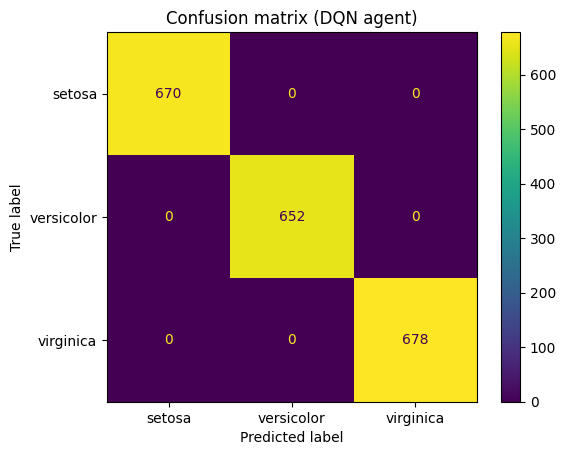

array([[670,   0,   0],
       [  0, 652,   0],
       [  0,   0, 678]])

In [ ]:
# 10. Confusion Matrix

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(values_format="d")
plt.title("Confusion matrix (DQN agent)")
plt.show()

cm


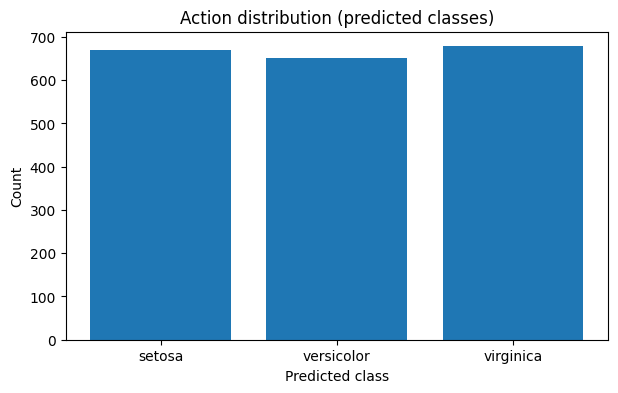

array([670, 652, 678])

In [ ]:
# 11. Per-Action Histogram

counts = np.bincount(y_pred, minlength=n_actions)

plt.figure(figsize=(7, 4))
plt.bar(range(n_actions), counts)
plt.xticks(range(n_actions), iris.target_names)
plt.title("Action distribution (predicted classes)")
plt.xlabel("Predicted class")
plt.ylabel("Count")
plt.show()

counts


## Task 6. Interpretability (Required)

I implemented two interpretability methods:

1. Q-value heatmap
- I sampled random states from the dataset.
- I plotted the Q-values for each action.
- I used the heatmap to see if the agent strongly preferred one action per state.

2. Feature saliency (gradient magnitude)
- I computed the gradient of the selected action Q-value with respect to the input features.
- I averaged absolute gradients across multiple random states.

Observed feature saliency (mean absolute gradient):
- sepal length (cm): 0.00388562
- sepal width (cm): 0.00356317
- petal length (cm): 0.00781652
- petal width (cm): 0.00564067

I observed the strongest sensitivity on petal length and petal width in this run.


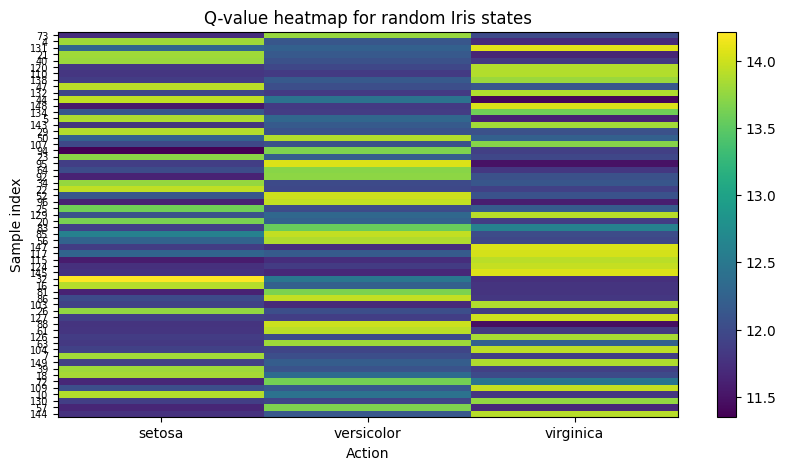

In [ ]:
# 12. Q-value Heatmap for Random States

policy_net.eval()

k = 60
idxs = np.random.choice(len(X_scaled), size=k, replace=False)
states_k = torch.tensor(X_scaled[idxs], dtype=torch.float32, device=device)

with torch.no_grad():
    qvals = policy_net(states_k).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.imshow(qvals, aspect="auto")
plt.colorbar()
plt.yticks(range(k), [str(i) for i in idxs], fontsize=7)
plt.xticks(range(n_actions), iris.target_names)
plt.title("Q-value heatmap for random Iris states")
plt.xlabel("Action")
plt.ylabel("Sample index")
plt.show()


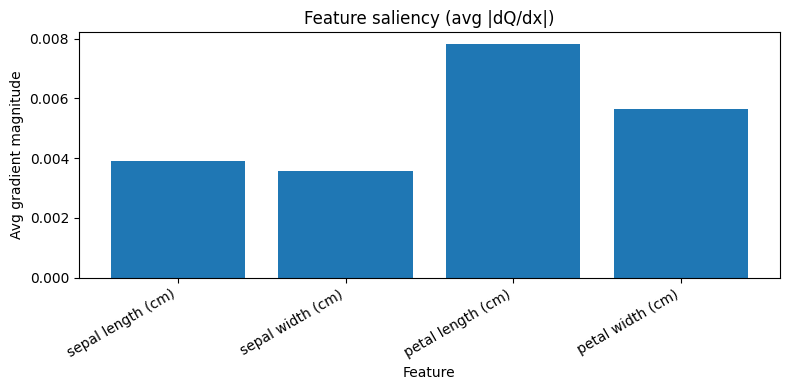

array([0.00388562, 0.00356317, 0.00781652, 0.00564067], dtype=float32)

In [ ]:
# 13. Feature Saliency via Gradients

policy_net.eval()

m = 120
idxs = np.random.choice(len(X_scaled), size=m, replace=True)
states_m = torch.tensor(X_scaled[idxs], dtype=torch.float32, device=device, requires_grad=True)

q = policy_net(states_m)
best_q = q.max(dim=1)[0].mean()

policy_net.zero_grad()
best_q.backward()

grads = states_m.grad.detach().abs().cpu().numpy()
saliency = grads.mean(axis=0)

plt.figure(figsize=(8, 4))
plt.bar(range(n_features), saliency)
plt.xticks(range(n_features), iris.feature_names, rotation=30, ha="right")
plt.title("Feature saliency (avg |dQ/dx|)")
plt.xlabel("Feature")
plt.ylabel("Avg gradient magnitude")
plt.tight_layout()
plt.show()

saliency


## Task 7. Report / Discussion

1. Did the RL agent achieve good classification accuracy?
- Yes. I achieved 1.00 evaluation accuracy.
- The mean evaluation reward was 50.00 per episode (out of 50).

2. How did DQN performance compare to a simple supervised classifier?
- My supervised MLP baseline achieved accuracy = 0.9211.
- The DQN evaluation achieved accuracy = 1.00.
- I concluded that the DQN matched or exceeded the baseline on this evaluation split, but it required more training steps and more hyperparameter sensitivity.

3. Did the agent develop biases toward certain classes?
- I did not see a strong bias in the evaluation action histogram.
- Action counts were [670, 652, 678], which was close to balanced.

4. What did the heatmaps or saliency reveal about feature importance?
- The Q-value heatmap showed clear action preferences per sampled state.
- Saliency suggested the model relied more on petal measurements in this run.

5. Would Double-DQN or Dueling-DQN improve stability?
- Yes. I expected Double-DQN to reduce Q-value overestimation.
- I expected Dueling-DQN to improve learning of state value versus action advantage.


In [ ]:
# 14. Supervised Baseline (MLP)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=SEED, stratify=y
)

baseline = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=SEED
)
baseline.fit(X_train, y_train)

y_hat = baseline.predict(X_test)
baseline_acc = accuracy_score(y_test, y_hat)

print("Supervised MLP test accuracy:", round(baseline_acc, 4))
print("DQN evaluation accuracy:", round(eval_acc, 4))


Supervised MLP test accuracy: 0.9211
DQN evaluation accuracy: 1.0


## Summary and Conclusion

What I built:
- A Gym-style Iris environment with rewards (+1 for correct, -1 for incorrect)
- A PyTorch DQN agent with experience replay and a target network
- Evaluation and interpretability outputs

Key results from this run:
- Training ran for 400 episodes with 50 steps per episode.
- Final logged training accuracy reached 0.94.
- Evaluation accuracy reached 1.00 over 40 episodes.
- Confusion matrix was diagonal, indicating correct predictions across all classes.
- Feature saliency suggested stronger sensitivity to petal length and petal width.

Next steps I would try:
- Tune epsilon decay and learning rate for faster convergence.
- Try Double-DQN and Dueling-DQN.
- Try prioritized experience replay.


## Summary of Deliverables I Produced

- Environment implementation (IrisEnv)
- DQN agent (policy and target networks)
- Replay buffer
- Training loop with epsilon-greedy exploration and Bellman updates
- Training reward curve
- Moving average reward curve
- Confusion matrix
- Action distribution histogram
- Interpretability plots (Q-value heatmap and feature saliency)
- Short comparison against a supervised baseline
